<div style="text-align: center; font-size: 30px; font-weight: bold;">
Movement Intention Prediction
<br> -------------- <br> 
Pipeline Riemann SVM
<br> -------------- <br>
Grid Search
</div>

## Introduction

This notebook aims to gather the results of the grid search for the best hyperparameters for the models used in the `RIEMANN SVM` movement intention prediction pipeline. The hyperparameters search has been performed on the ISAE Supaero's HPC cluster. All the training environnment and script can be found in the `src/training/RIEMANN_SVM_MVT_INT_grid_search/`. The results for each grid search are stored in the `results/` folder next to this notebook.

To perform the training, we added a new epoch to the training set. This epoch is situated just before the movement onset (flexion or extension) and is used to train the model to predict the movement intention. The training set is then composed of 3 epochs: the rest epoch, the movement epoch and the movement intention epoch. The movement intention epoch is used to train the model to predict the movement intention, labeled 1 as 'movement intention'. The two other epochs are labeled as 0 'no movement intention'. The test set is composed of the same epochs. More information about the preprocessing and epoching can be found in the [`data_preparation`](./../ml_eeg_tools_example/data_preparation.ipynb) notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
# Names and paths
RESULT_PATH = './../../src/training/RIEMANN_SVM_MVT_INT_grid_search/results/'
NAME_RESULTS = 'RSVM_MVT_INT_search_preproc'
SAVE_PATH = './results/'
NAME_SAVE = 'RSVM_MVT_INT_search_preproc_gathered'

In [3]:
# Gather results
def gather_results(path, name, save_path, name_save):
    files = [f for f in os.listdir(path) if f.startswith(name) and f.endswith('.csv')]
    files = [os.path.join(path, f) for f in files]
    dfs = []
    for file in files:
        df = pd.read_csv(file)
        dfs.append(df)
    result_df = pd.concat(dfs, ignore_index=True)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    result_df.to_csv(os.path.join(save_path, name_save + '.csv'), index=False)
    return result_df

In [4]:
# Load results
def boxplot_results(result_df, parameters, scores=['score_A', 'score_B', 'score_C', 'score_X']):
    fig, ax = plt.subplots(len(scores), len(parameters), figsize=(15, 20))
    fig.suptitle('Hyperparameter tuning')

    for i, score in enumerate(scores):
        for j, param in enumerate(parameters):
            sns.boxplot(x=param, y=score, data=result_df, ax=ax[i, j])
            ax[i, j].set_title(score + ' ' + param)

    plt.tight_layout()
    plt.show()

In [5]:
def maxplot_results(result_df, parameters):
# max for each param and score
    for p in parameters:
        max_score_A = result_df.groupby(p)['score_A'].max()
        max_score_B = result_df.groupby(p)['score_B'].max()
        max_score_C = result_df.groupby(p)['score_C'].max()
        max_score_X = result_df.groupby(p)['score_X'].max()

        max_score_A = max_score_A.reset_index()
        max_score_B = max_score_B.reset_index()
        max_score_C = max_score_C.reset_index()
        max_score_X = max_score_X.reset_index()

        fig, ax = plt.subplots(2, 2, figsize=(15, 10))
        ax[0, 0].scatter(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
        ax[0, 0].set_xlabel(p)
        ax[0, 0].set_ylabel('score_A')
        ax[0, 0].set_title('score_A')
        ax[0, 0].legend()

        ax[0, 1].scatter(max_score_B[p], max_score_B['score_B'], label='score_B', marker='o')
        ax[0, 1].set_xlabel(p)
        ax[0, 1].set_ylabel('score_B')
        ax[0, 1].set_title('score_B')
        ax[0, 1].legend()

        ax[1, 0].scatter(max_score_C[p], max_score_C['score_C'], label='score_C', marker='o')
        ax[1, 0].set_xlabel(p)
        ax[1, 0].set_ylabel('score_C')
        ax[1, 0].set_title('score_C')
        ax[1, 0].legend()

        ax[1, 1].scatter(max_score_X[p], max_score_X['score_X'], label='score_X', marker='o')
        ax[1, 1].set_xlabel(p)
        ax[1, 1].set_ylabel('score_X')
        ax[1, 1].set_title('score_X')
        ax[1, 1].legend()
        plt.tight_layout()
        plt.show()

In [6]:
def maxplot_all_results(result_df, param):
    fig, ax = plt.subplots(1, len(param), figsize=(15, 10))

    for p in param:
        max_score_A = result_df.groupby(p)['score_A'].max()
        max_score_B = result_df.groupby(p)['score_B'].max()
        max_score_C = result_df.groupby(p)['score_C'].max()
        max_score_X = result_df.groupby(p)['score_X'].max()

        max_score_A = max_score_A.reset_index()
        max_score_B = max_score_B.reset_index()
        max_score_C = max_score_C.reset_index()
        max_score_X = max_score_X.reset_index()

        ax[param.index(p)].plot(max_score_A[p], max_score_A['score_A'], label='score_A', marker='o')
        ax[param.index(p)].plot(max_score_B[p], max_score_B['score_B'], label='score_B', marker='^')
        ax[param.index(p)].plot(max_score_C[p], max_score_C['score_C'], label='score_C', marker='s')
        ax[param.index(p)].plot(max_score_C[p], max_score_X['score_X'], label='score_X', marker='.')
        ax[param.index(p)].set_title(p)

        
    plt.legend()
    plt.show()



## Grid Search 1 : Length and onset of the epochs

### Preprocessing hyperparameters : 
```python
# params_dict_lists : paramters to be used in the grid search for the preprocessing
params_dict_lists = { #V1
    'EPOCHS_TMIN': [-1, -0.5, 0], # 3 -> start time of the epoch from the movement onset (in seconds)
    'EPOCHS_LENGTH': [4, 3, 2.5, 2, 1.8, 1.7, 1.5, 1.2, 1, 0.5], # 10 -> length of the epoch (in seconds) [TO BE USED IF NO EPOCHS_TMAX IS USED]
    # 'EPOCHS_TMAX': [0, 0.5, 1], # 3 -> end time of the epoch from the movement onset (in seconds) [TO BE USED IF NO EPOCHS_LENGTH IS USED]
    'EPOCHS_EMPTY_FROM_MVT_TMIN': [-8, -7, -6, -5, -4], # 5 -> start time of the empty epoch from the movement onset
    'EPOCHS_INTENTION_FROM_MVT_TMIN': [-4, -3, -2.8, -2.5, -2.2, -2, -1.8, -1.5, -1.2], # 9 -> OPTIONAL: start time of the intention epoch from the movement onset
    'FMIN': [9], # 1 -> min frequency
    'FMAX': [30], # 1 -> max frequency
} # 3*10*5*9*1*1 = 1350 combinations -> 8 nodes, 6cores/node 1350/48 = 28.125 -> * 11min = 5h

# params_dict_lists_exclude : parameters to be excluded from the grid search for the preprocessing (same keys as params_dict_lists)
params_dict_lists_exclude = None

# params_exclude_rules : rules to exclude some parameters combinations
# Example: params_exclude_rules = [lambda params: params['FMIN'] >= params['FMAX'], ...]
params_exclude_rules = [lambda params: params['EPOCHS_INTENTION_FROM_MVT_TMIN'] + params['EPOCHS_LENGTH'] > 0]
```
-----------------------------

### Pipeline hyperparameters : 
```python
cov = Covariances()
ts = TangentSpace()
ss = StandardScaler()
clf = SVC()
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('clf', clf)])

# pipelines_dict_lists : paramteres to be used in the grid search for the pipeline
pipelines_dict_lists = {
    'pipeline_1': {
    'pipeline': [pipeline],
    'cov__estimator': ['oas'], # 1
    },
}
pipelines_dict_lists_exclude = None
pipelines_exclude_rules = None
```

In [8]:
Version = 'V1'
path = RESULT_PATH + Version + '/'
name_save = NAME_SAVE + '_' + Version
result_df_v1 = gather_results(path, NAME_RESULTS, SAVE_PATH, name_save)

In [9]:
result_df_v1 = pd.read_csv(SAVE_PATH + name_save + ".csv")

In [10]:
result_df_v1.describe()

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_INTENTION_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,VERSION
count,930.000000,930.000000,930.000000,930.000000,930.0,930.0,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.0,930.0,930.0,930.0
mean,-6.000000,-2.567742,1.496774,-0.500000,30.0,9.0,0.502688,0.503892,0.504454,0.502991,513.845393,567.591968,3146.048194,-1.0,42.0,4.0,1.0
std,1.414975,0.799376,0.686868,0.408468,0.0,0.0,0.013777,0.007611,0.008107,0.012594,26.636887,60.707482,941.031508,0.0,0.0,0.0,0.0
min,-8.000000,-4.000000,0.500000,-1.000000,30.0,9.0,0.415613,0.499254,0.497900,0.426321,458.153581,410.551725,866.410156,-1.0,42.0,4.0,1.0
25%,-7.000000,-3.000000,1.000000,-1.000000,30.0,9.0,0.499839,0.500000,0.500000,0.499861,496.882230,526.886354,2690.894531,-1.0,42.0,4.0,1.0
50%,-6.000000,-2.500000,1.500000,-0.500000,30.0,9.0,0.500329,0.500415,0.500647,0.500584,511.830156,565.278743,3033.250000,-1.0,42.0,4.0,1.0
75%,-5.000000,-2.000000,1.800000,0.000000,30.0,9.0,0.504984,0.503955,0.505508,0.504081,524.599994,609.088880,3435.841797,-1.0,42.0,4.0,1.0
max,-4.000000,-1.200000,4.000000,0.000000,30.0,9.0,0.547046,0.543590,0.545161,0.547634,656.852949,773.005910,7391.027344,-1.0,42.0,4.0,1.0


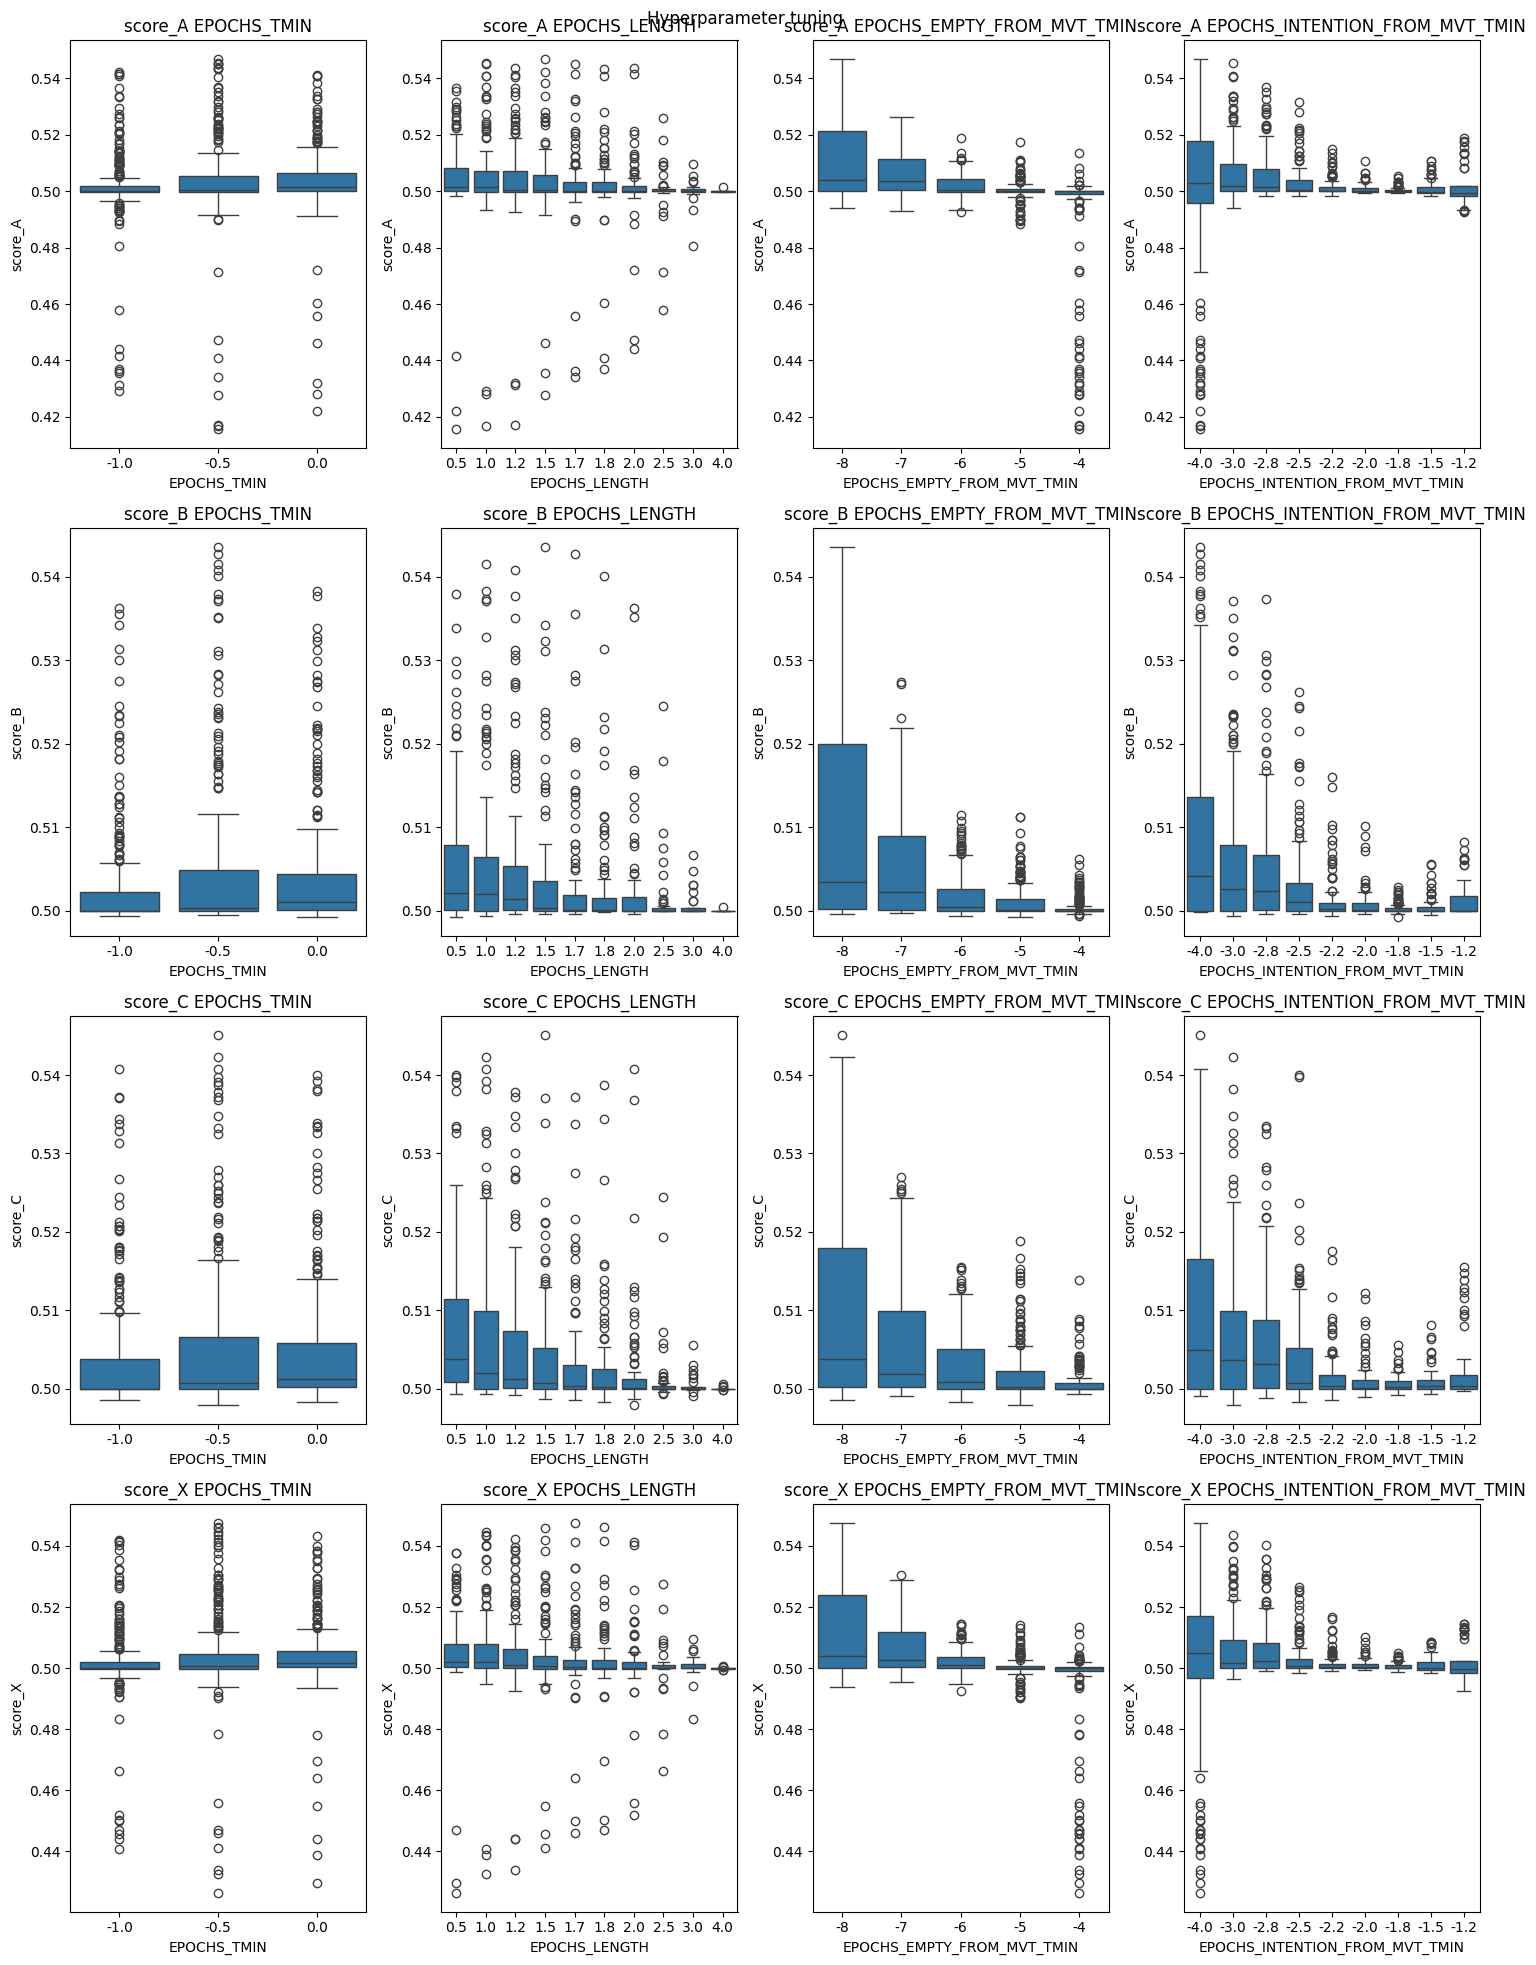

In [11]:
parameters_v1 = ['EPOCHS_TMIN', 'EPOCHS_LENGTH', 'EPOCHS_EMPTY_FROM_MVT_TMIN', 'EPOCHS_INTENTION_FROM_MVT_TMIN']
boxplot_results(result_df_v1, parameters_v1)

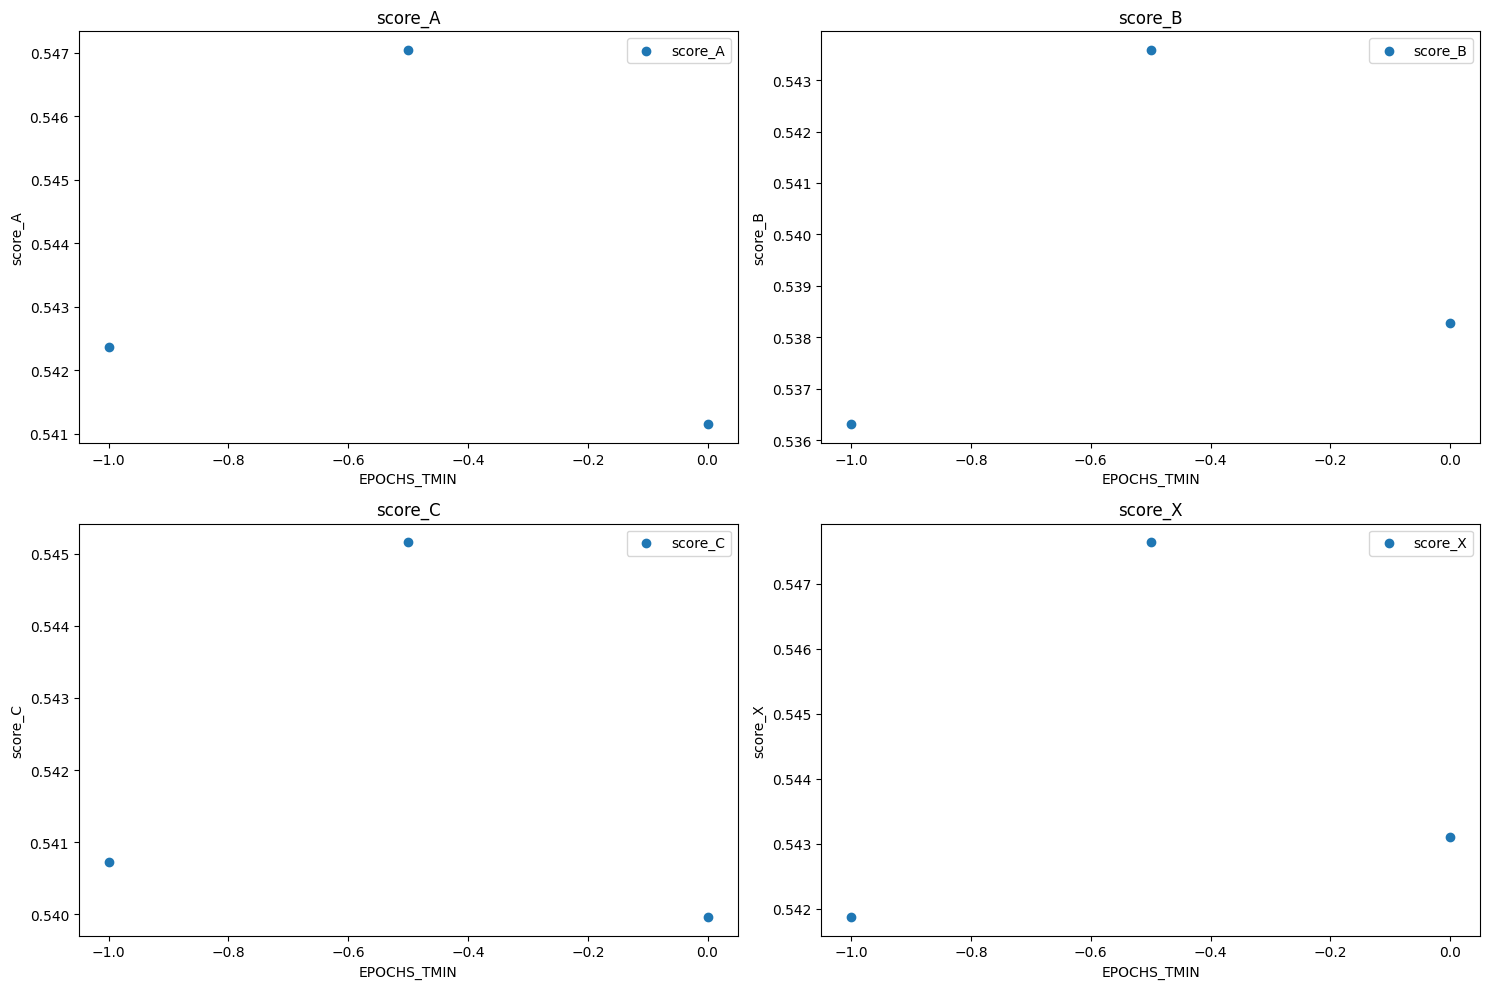

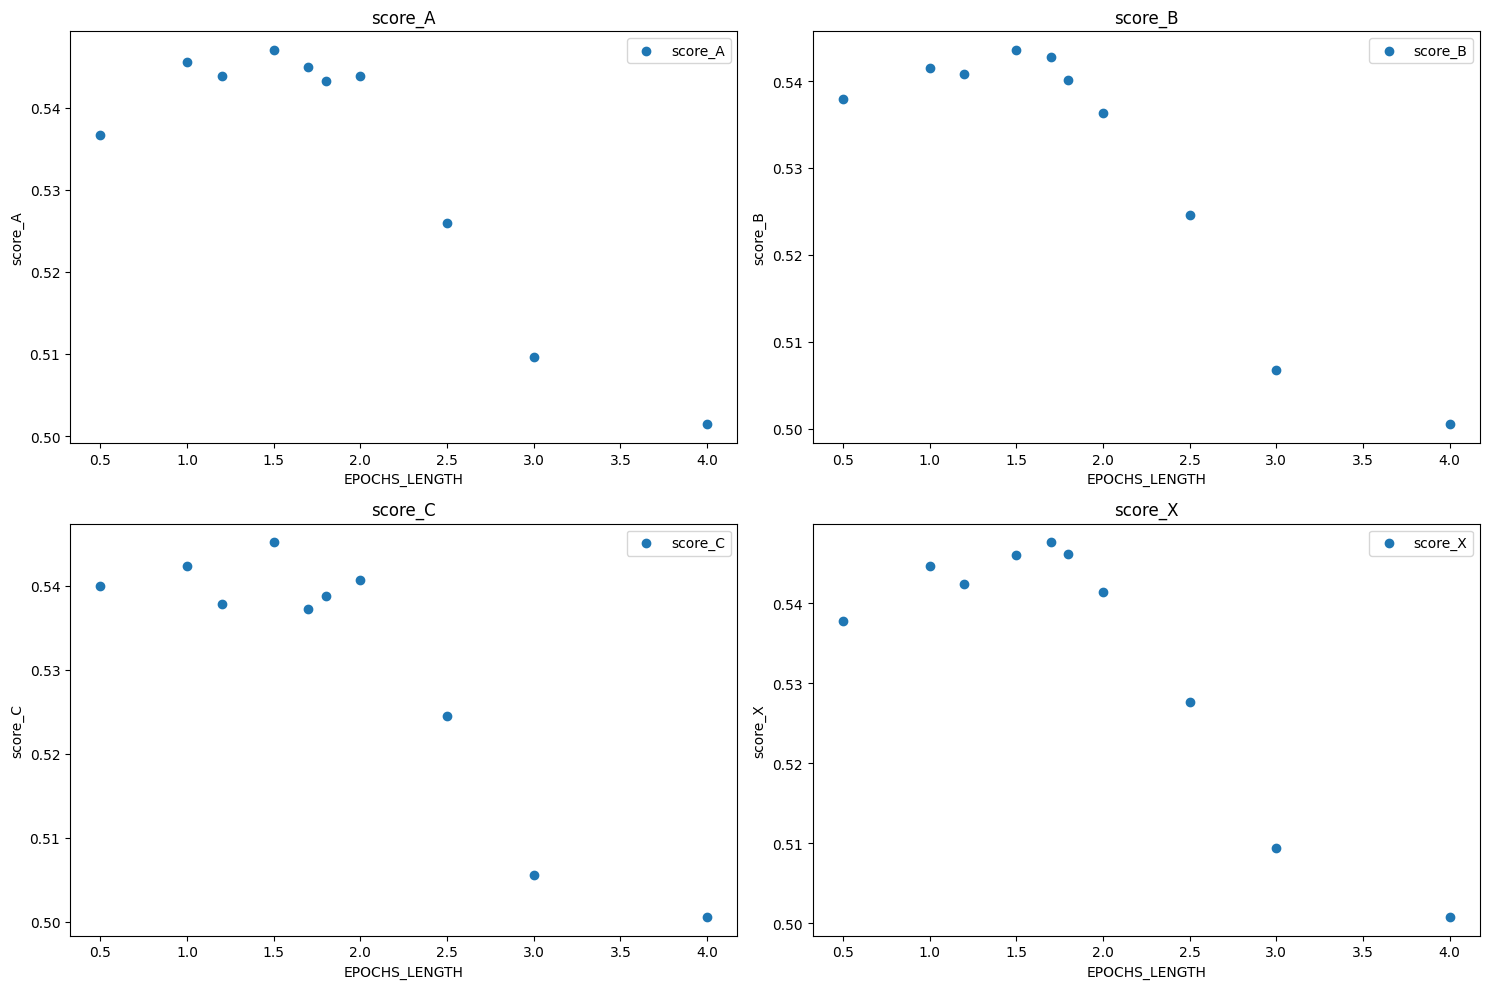

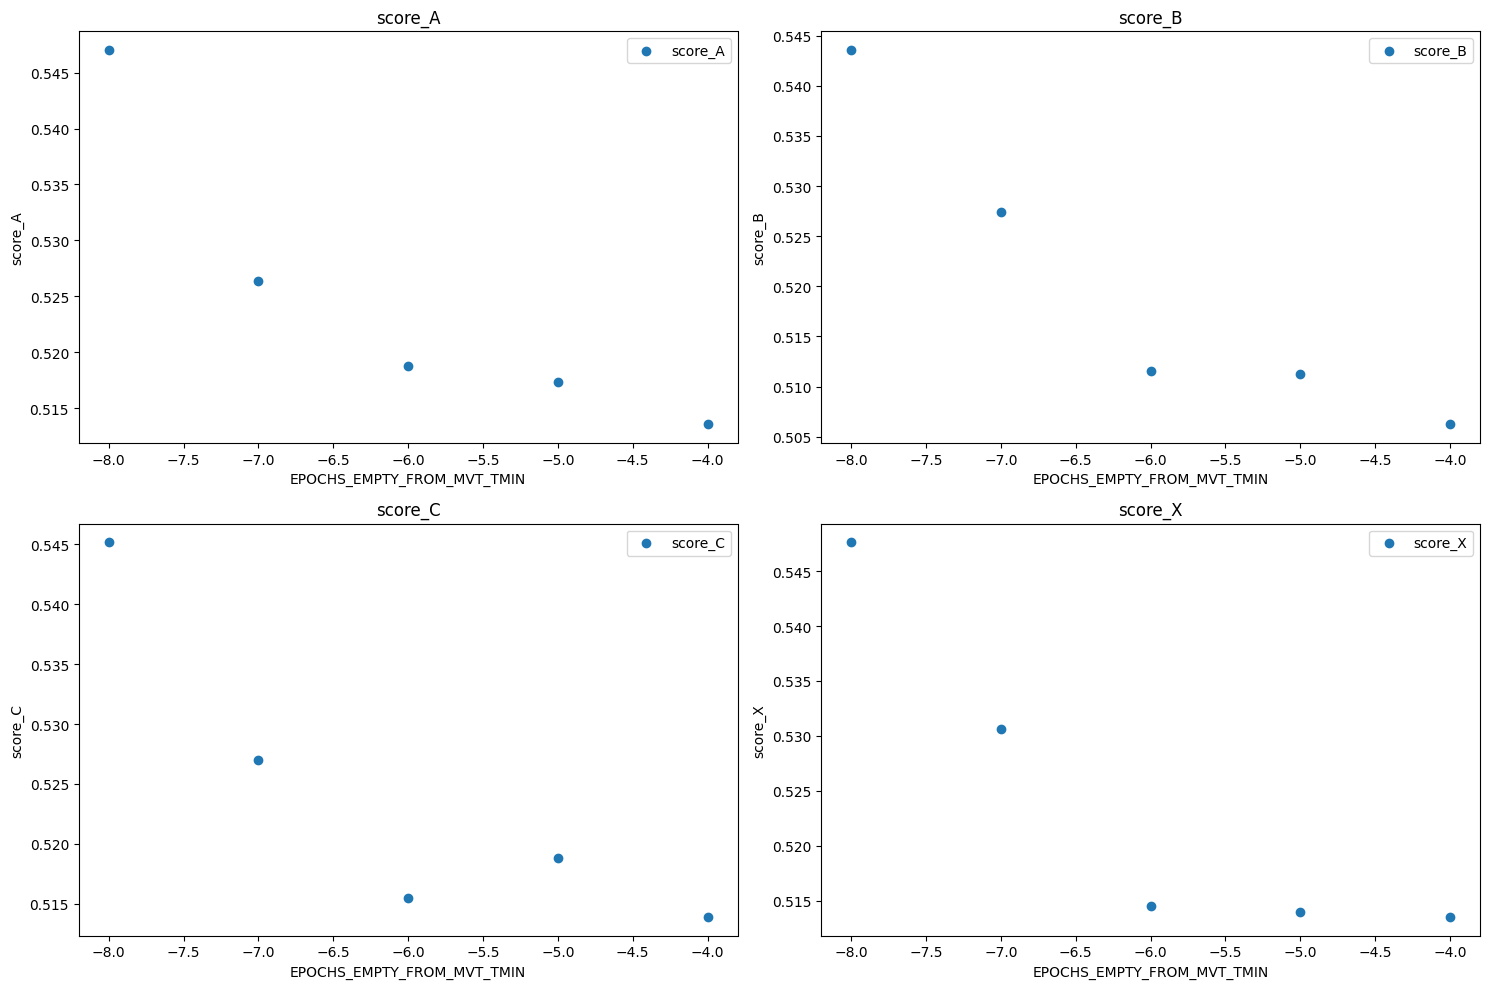

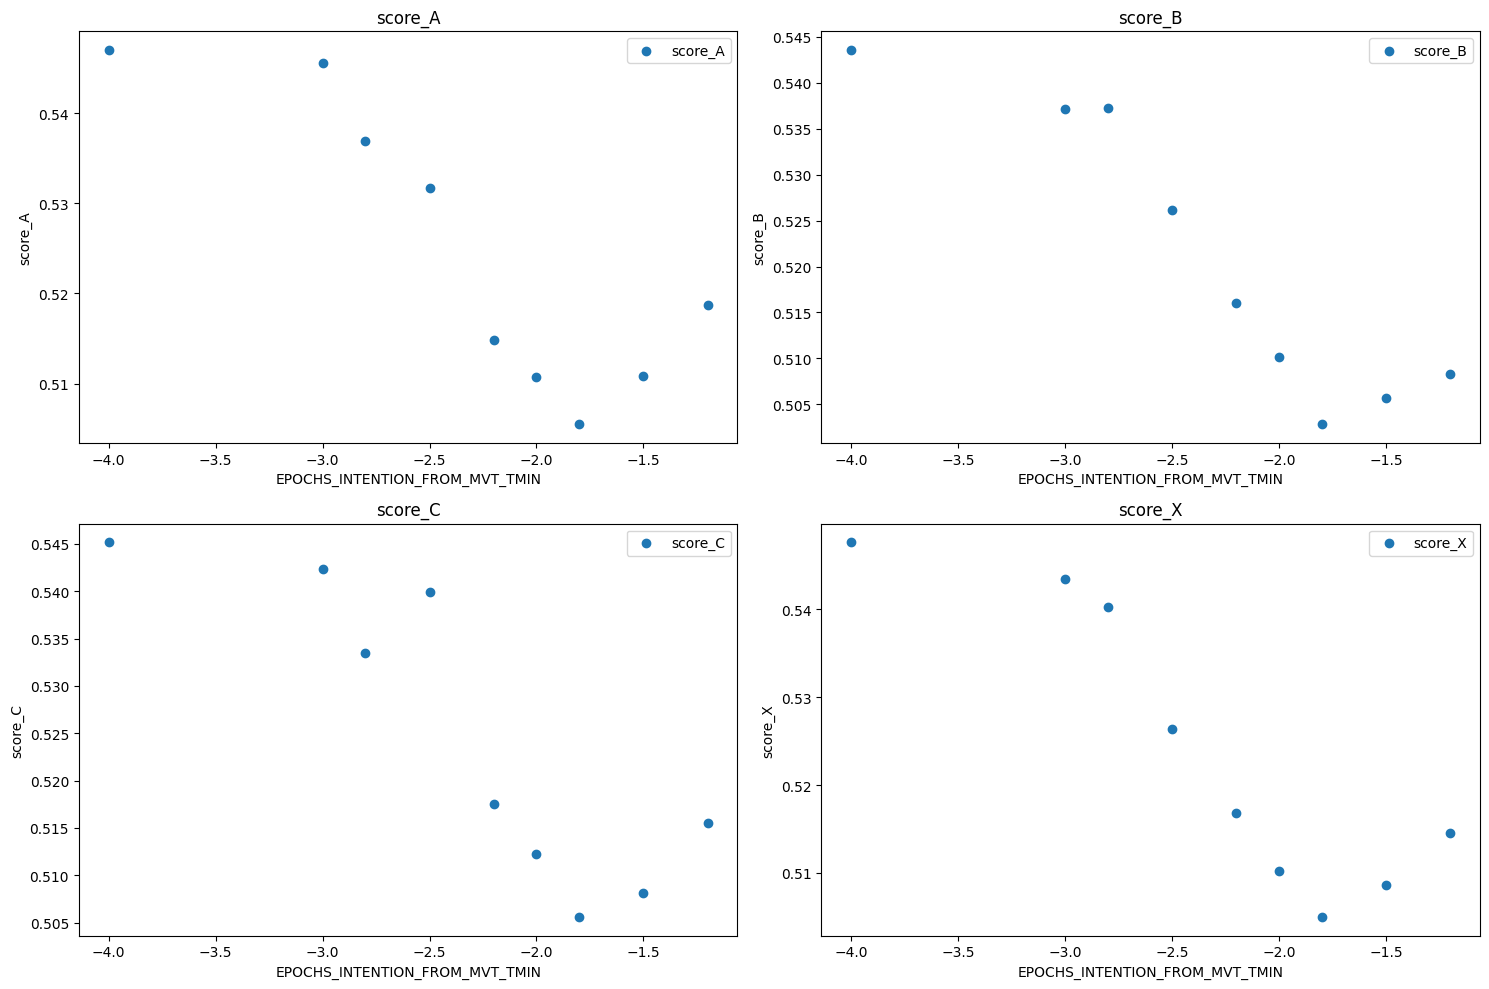

In [12]:
maxplot_results(result_df_v1, parameters_v1)

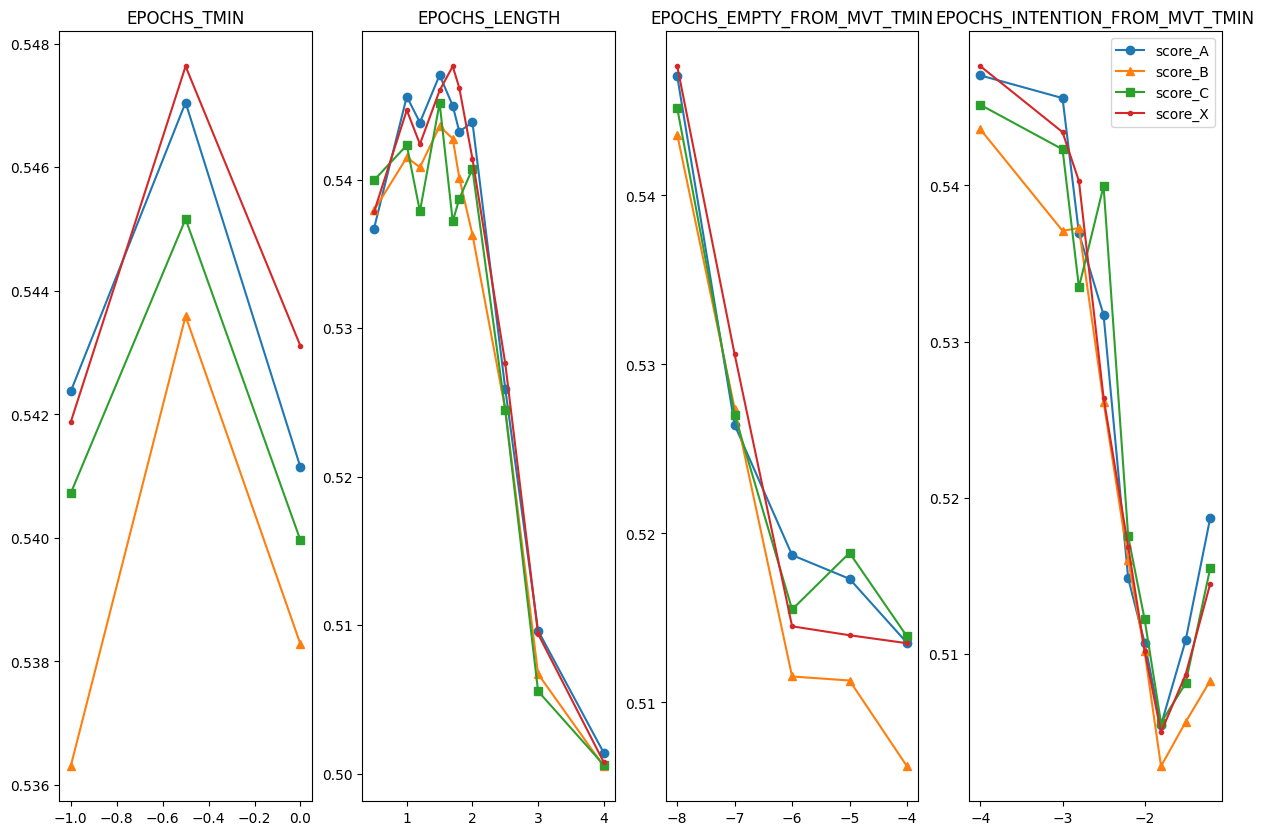

In [14]:
maxplot_all_results(result_df_v1, parameters_v1)

In [15]:
# display all columns
pd.set_option('display.max_columns', None)

In [16]:
# sort by score A
result_df = result_df_v1.sort_values(by='score_A', ascending=False)
result_df.head(3)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_INTENTION_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED
94,-8,-4.0,1.5,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.547046,0.543590,0.545161,0.546003,497.422410,486.972765,2991.359375,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True
284,-8,-3.0,1.0,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.545596,0.537097,0.542317,0.543418,522.339489,530.644821,2991.230469,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True
560,-8,-4.0,1.0,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.545054,0.541495,0.540727,0.544684,476.024928,446.127335,2690.855469,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True


In [17]:
# sort by score B
result_df = result_df_v1.sort_values(by='score_B', ascending=False)
result_df.head(3)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_INTENTION_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED
94,-8,-4.0,1.5,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.547046,0.543590,0.545161,0.546003,497.422410,486.972765,2991.359375,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True
652,-8,-4.0,1.7,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.544976,0.542763,0.537187,0.547634,492.988194,562.016387,3566.593750,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True
560,-8,-4.0,1.0,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.545054,0.541495,0.540727,0.544684,476.024928,446.127335,2690.855469,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True


In [18]:
# sort by score C
result_df = result_df_v1.sort_values(by='score_C', ascending=False)
result_df.head(3)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_INTENTION_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED
94,-8,-4.0,1.5,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.547046,0.543590,0.545161,0.546003,497.422410,486.972765,2991.359375,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True
284,-8,-3.0,1.0,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.545596,0.537097,0.542317,0.543418,522.339489,530.644821,2991.230469,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True
560,-8,-4.0,1.0,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.545054,0.541495,0.540727,0.544684,476.024928,446.127335,2690.855469,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True


In [19]:
# sort mean of scores
result_df_v1['mean_score'] = result_df_v1[['score_A', 'score_B', 'score_C', 'score_X']].mean(axis=1)
result_df = result_df_v1.sort_values(by='mean_score', ascending=False)
result_df.head(3)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_INTENTION_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,mean_score
94,-8,-4.0,1.5,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.547046,0.543590,0.545161,0.546003,497.422410,486.972765,2991.359375,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True,0.54545
652,-8,-4.0,1.7,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.544976,0.542763,0.537187,0.547634,492.988194,562.016387,3566.593750,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True,0.54314
560,-8,-4.0,1.0,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.545054,0.541495,0.540727,0.544684,476.024928,446.127335,2690.855469,./../../../data/raw/Data_npy/,-1,42,4,True,1,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True,0.54299


## Grid Search 2 : More points for the epochs length

In [7]:
Version = 'V2'
path = RESULT_PATH + Version + '/'
name_save = NAME_SAVE + '_' + Version
result_df_v2 = gather_results(path, NAME_RESULTS, SAVE_PATH, name_save)

In [8]:
result_df_v2 = pd.read_csv(SAVE_PATH + name_save + ".csv")
result_df_v2.describe()

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_INTENTION_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,VERSION
count,450.0,450.000000,450.000000,450.0,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.0,450.0,450.0,450.0
mean,-8.0,-2.490000,1.000000,-0.5,38.333333,11.866667,0.510781,0.514155,0.514116,0.511685,610.676326,557.509041,2226.139401,-1.0,42.0,4.0,2.0
std,0.0,1.522515,0.502555,0.0,12.924313,8.167511,0.025061,0.016552,0.016165,0.024420,121.460899,45.942036,882.110934,0.0,0.0,0.0,0.0
min,-8.0,-4.000000,0.500000,-0.5,20.000000,1.000000,0.429931,0.499416,0.498927,0.439297,478.859858,386.946568,857.046875,-1.0,42.0,4.0,2.0
25%,-8.0,-4.000000,0.500000,-0.5,30.000000,5.000000,0.499663,0.500000,0.500000,0.499094,502.803393,527.296510,1558.752930,-1.0,42.0,4.0,2.0
50%,-8.0,-2.600000,1.000000,-0.5,35.000000,12.000000,0.502262,0.500828,0.501569,0.502208,543.691124,560.454353,2388.566406,-1.0,42.0,4.0,2.0
75%,-8.0,-1.000000,1.400000,-0.5,50.000000,15.000000,0.532785,0.531312,0.531099,0.535120,729.931220,589.514912,2942.333008,-1.0,42.0,4.0,2.0
max,-8.0,-0.500000,2.000000,-0.5,60.000000,30.000000,0.555178,0.550875,0.550105,0.549638,934.503028,687.278701,3946.152344,-1.0,42.0,4.0,2.0


In [9]:
parameters_v2 = ['EPOCHS_LENGTH', 'EPOCHS_INTENTION_FROM_MVT_TMIN', 'FMIN', 'FMAX']
boxplot_results(result_df_v1, parameters_v2)

NameError: name 'result_df_v1' is not defined

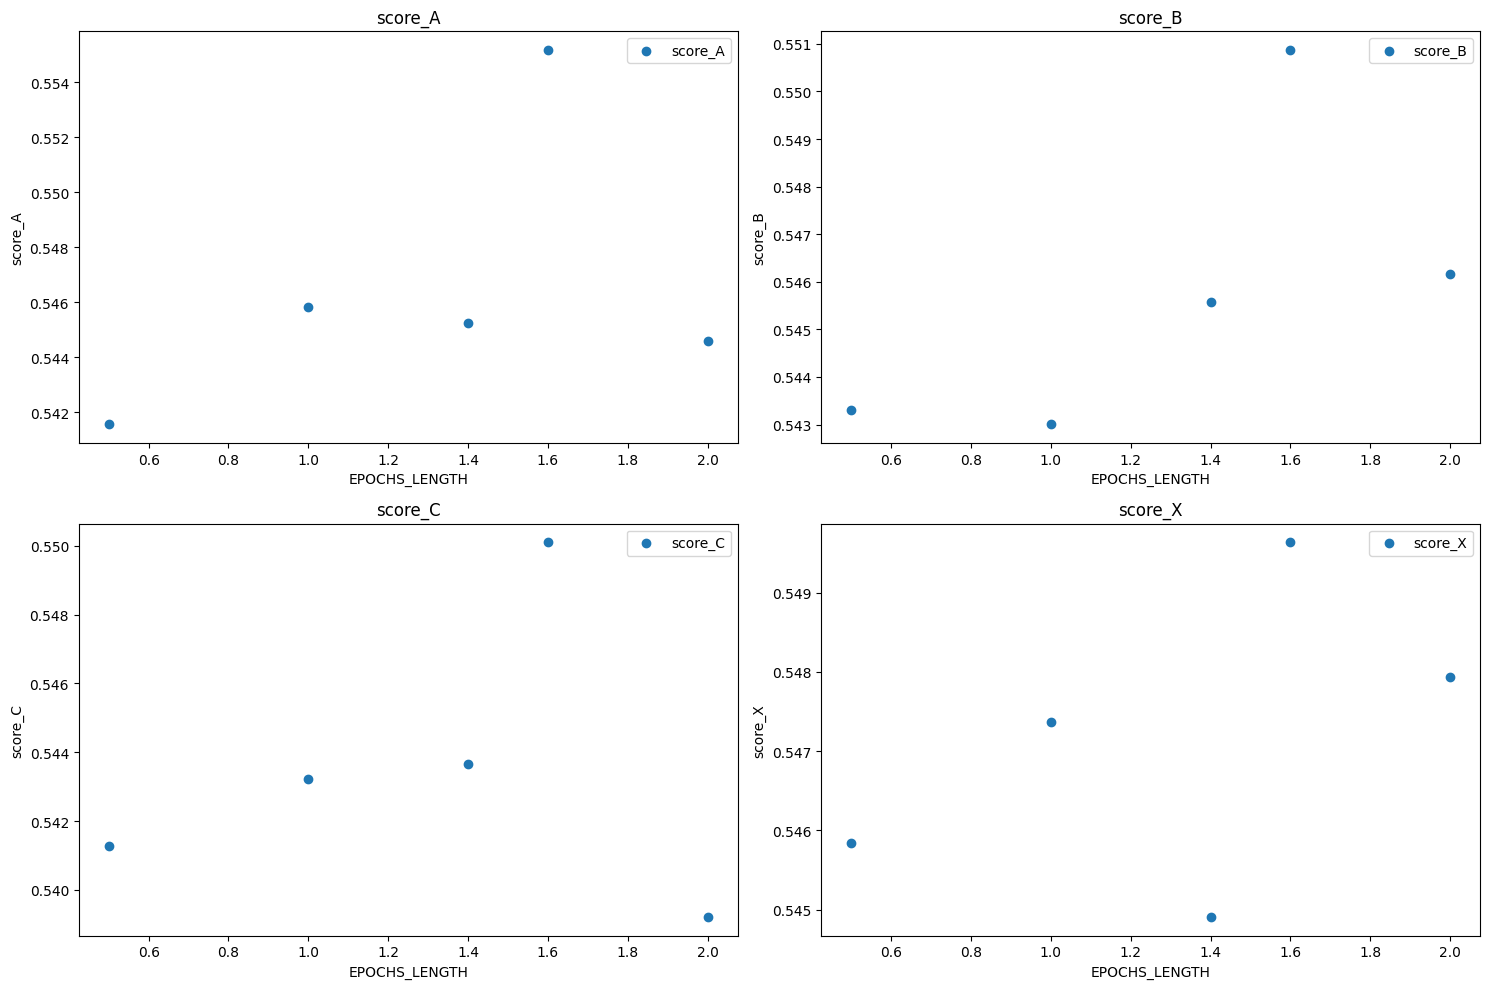

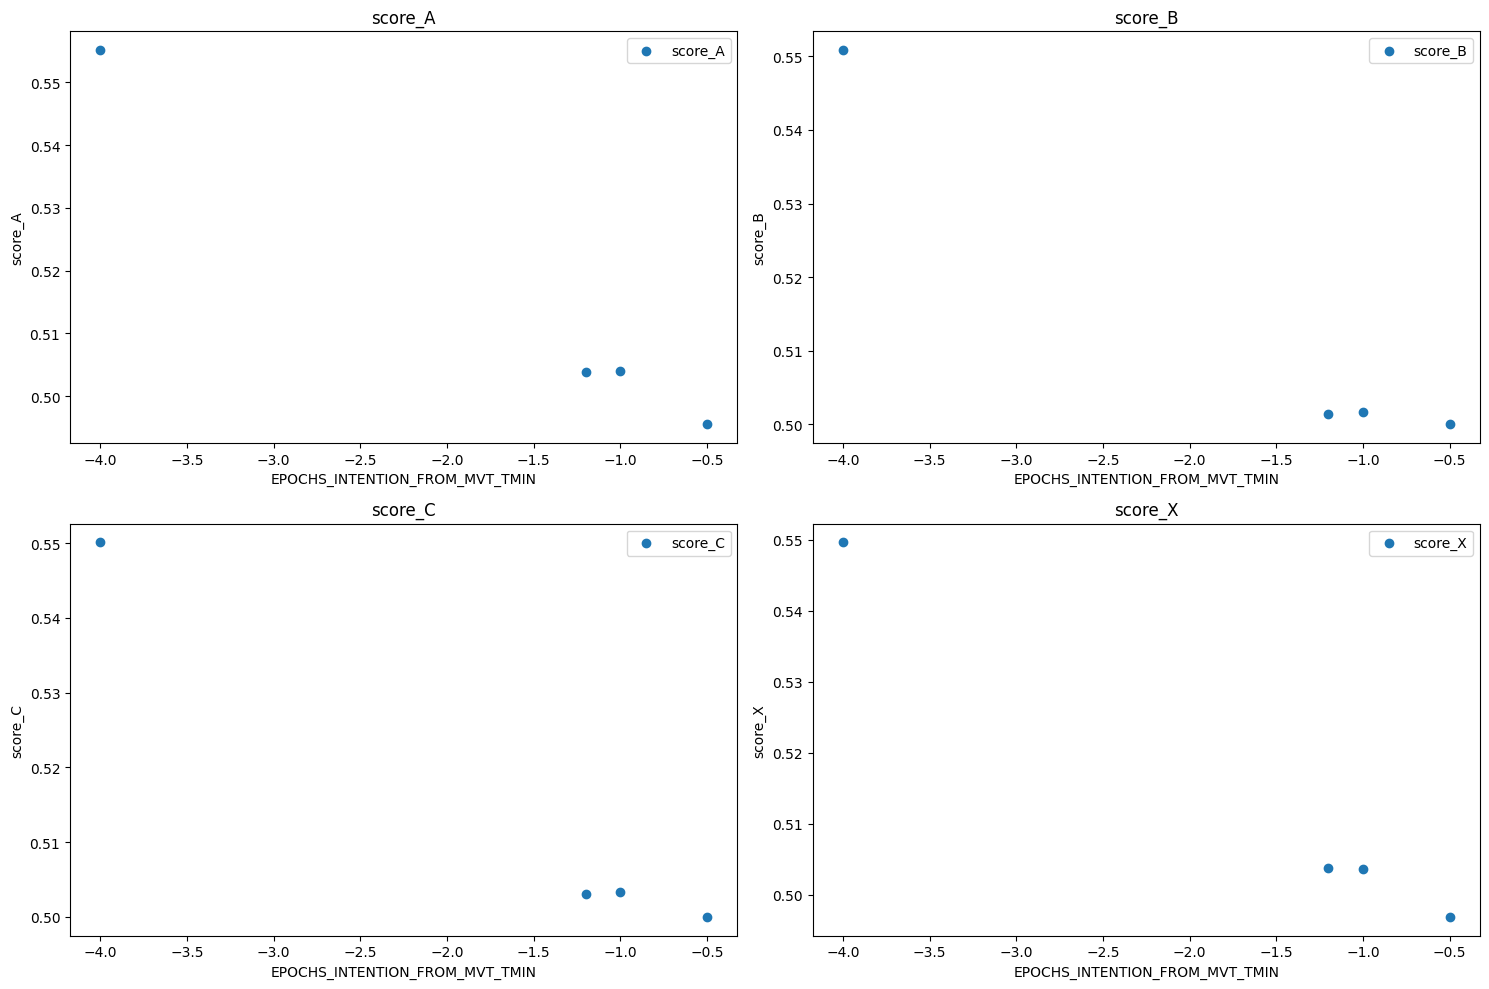

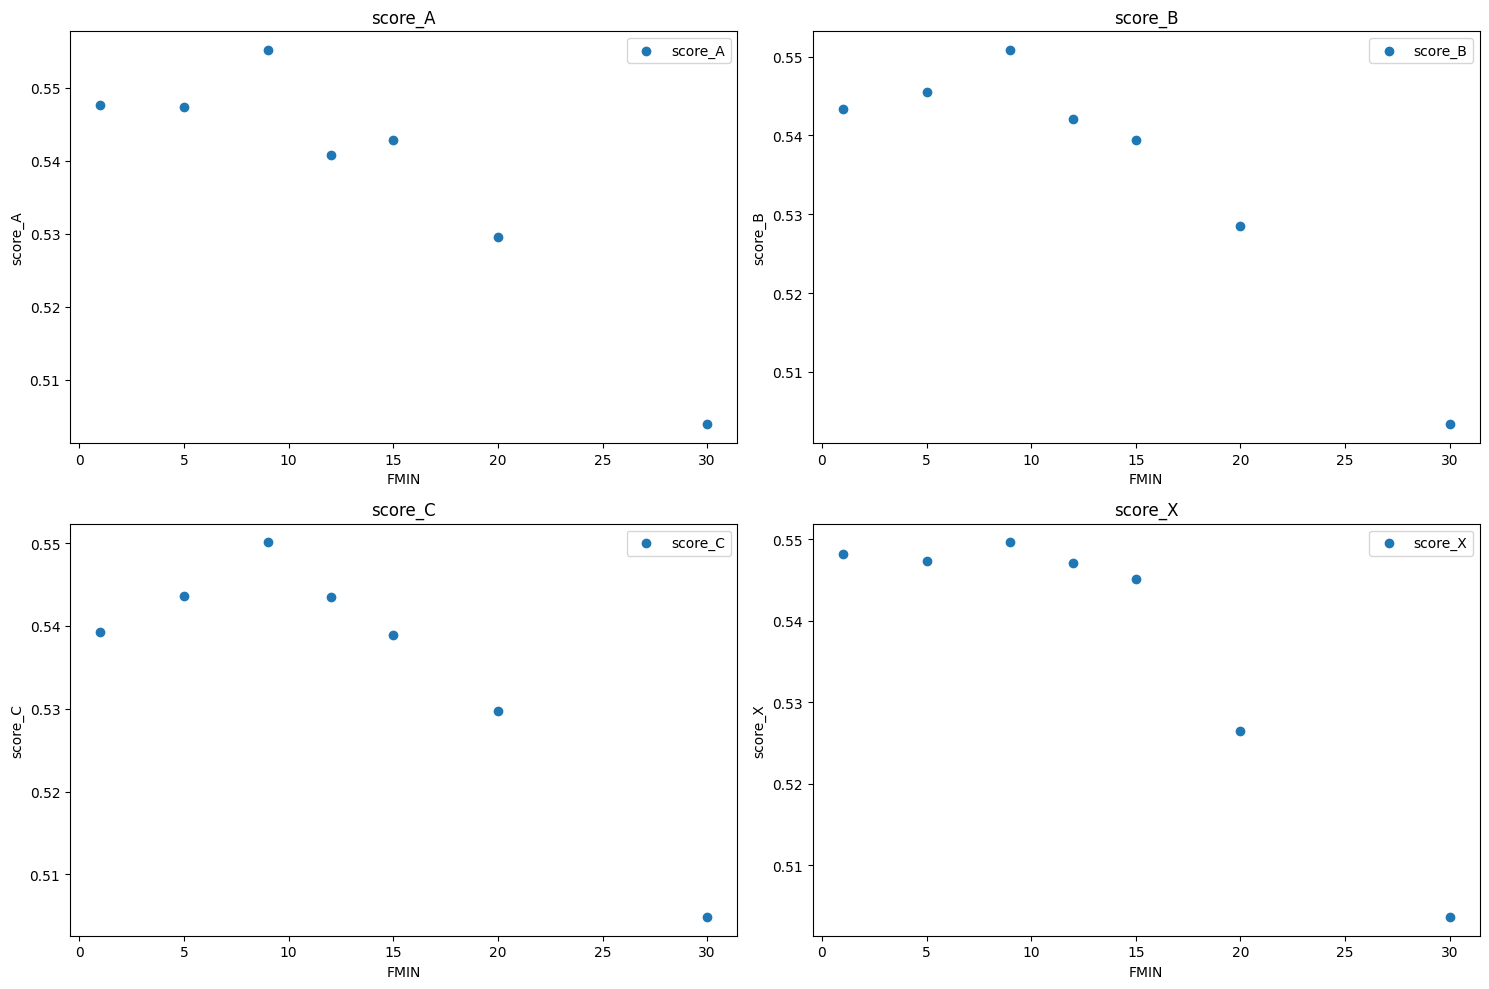

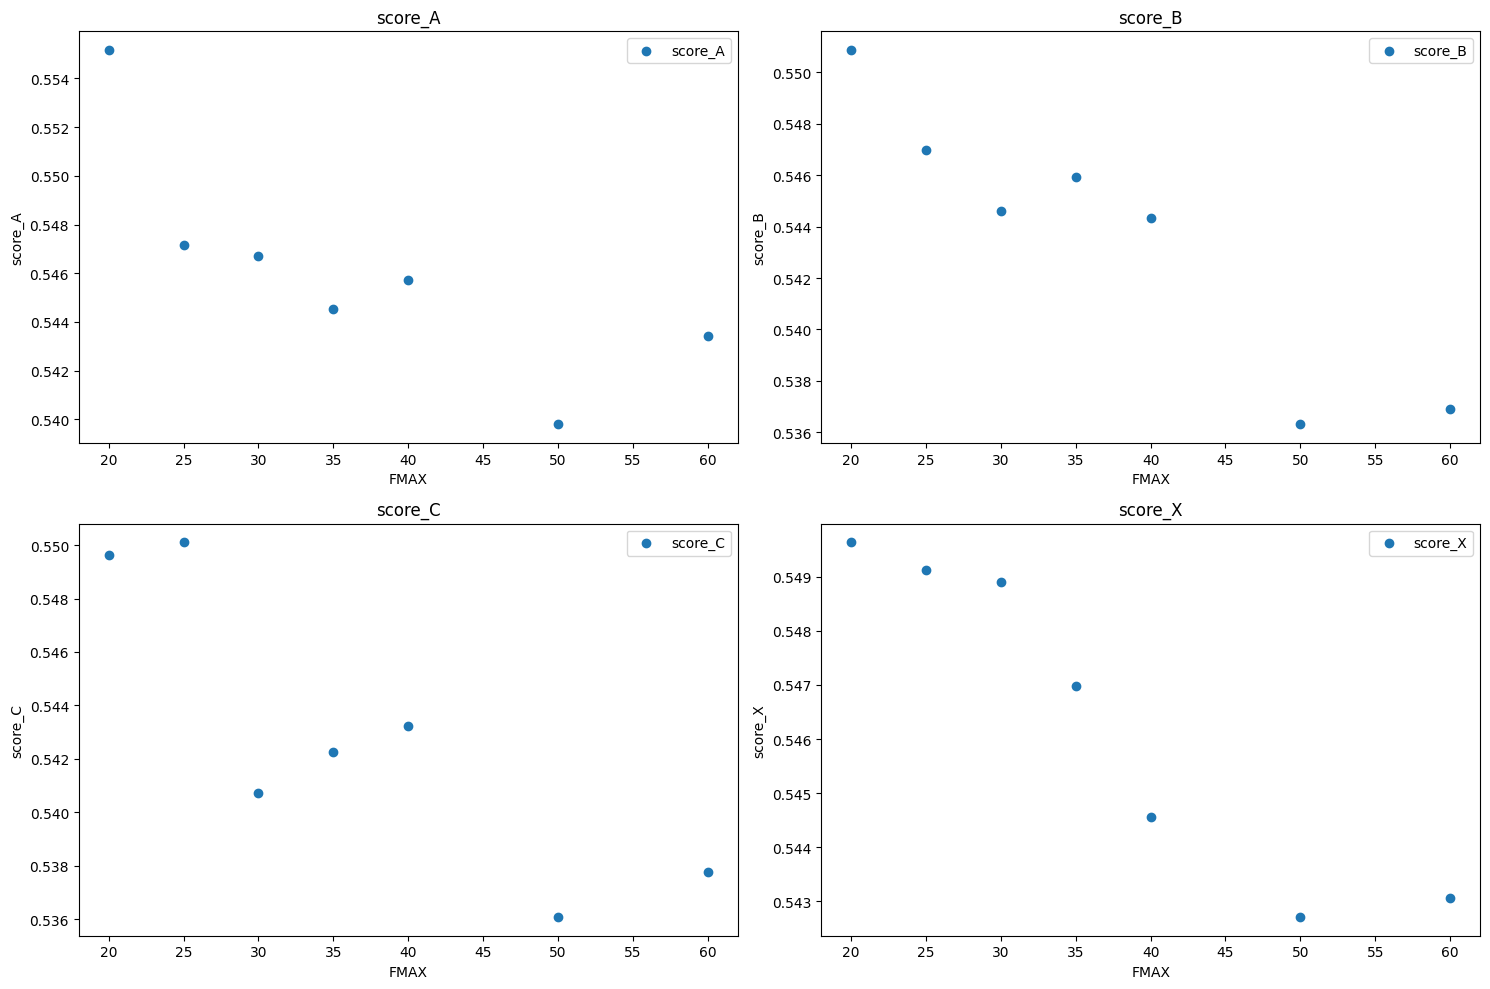

In [10]:
maxplot_results(result_df_v2, parameters_v2)

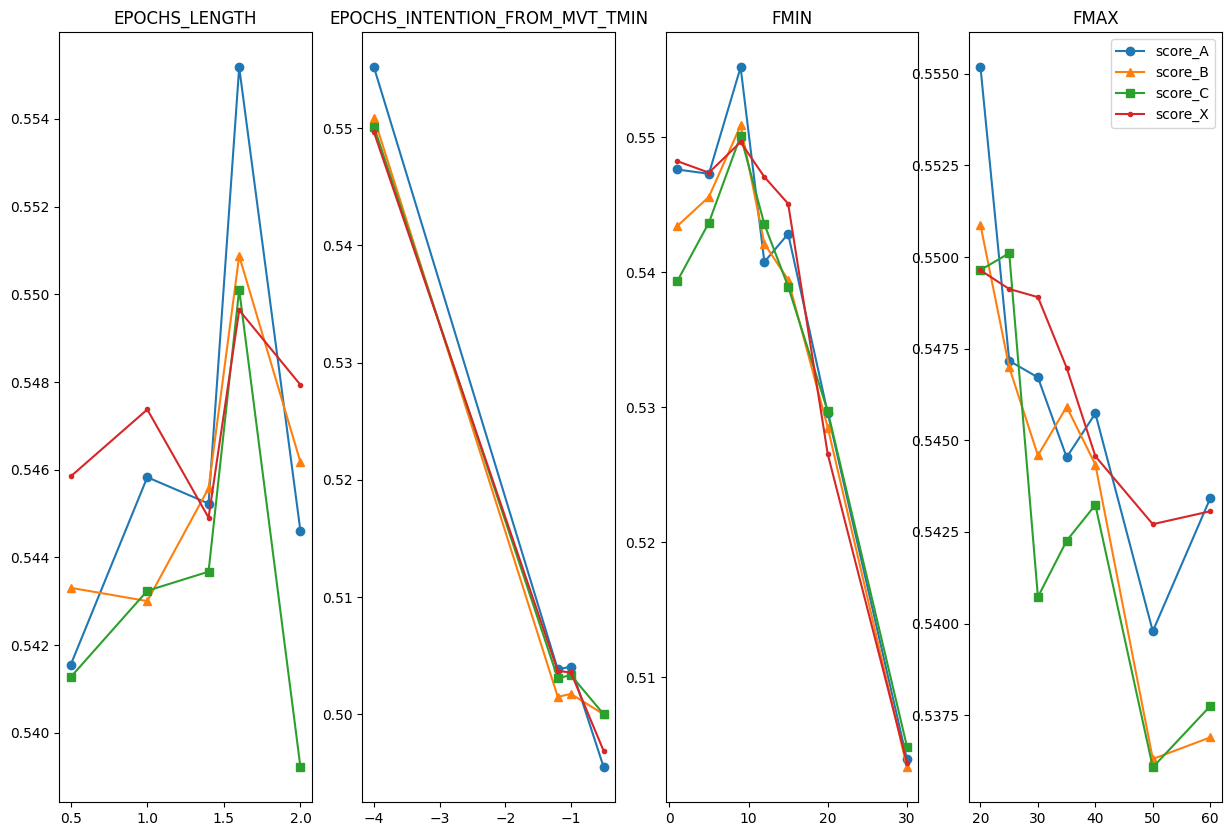

In [11]:
maxplot_all_results(result_df_v2, parameters_v2)

In [12]:
# mean of scores
# display all cols
pd.set_option('display.max_columns', None)
result_df_v2['mean_score'] = result_df_v2[['score_A', 'score_B', 'score_C', 'score_X']].mean(axis=1)
result_df = result_df_v2.sort_values(by='mean_score', ascending=False)
result_df.head(3)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_INTENTION_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,score_C,score_X,duration_preprocessing,duration_train,memory,FILE_PATH,NUMBER_OF_SESSIONS,RANDOM_STATE,N_SPLIT,BINARY_CLASSIFICATION,VERSION,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,mean_score
364,-8,-4.0,1.6,-0.5,20,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.555178,0.550875,0.549646,0.549638,717.289710,544.001959,3023.851562,./../../../data/raw/Data_npy/,-1,42,4,True,2,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True,0.551334
140,-8,-4.0,1.6,-0.5,25,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.547169,0.546993,0.550105,0.549128,500.492609,577.003654,3099.167969,./../../../data/raw/Data_npy/,-1,42,4,True,2,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True,0.548349
410,-8,-4.0,1.6,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.546716,0.544587,0.540562,0.548907,766.904829,559.919986,2391.652344,./../../../data/raw/Data_npy/,-1,42,4,True,2,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True,0.545193


In [25]:
# mean of scores
result_df_v2['mean_score'] = result_df_v2[['score_A', 'score_B', 'score_C', 'score_X']].mean(axis=1)
result_df = result_df_v2.sort_values(by='mean_score', ascending=False)
result_df.head(3)

,EPOCHS_EMPTY_FROM_MVT_TMIN,EPOCHS_INTENTION_FROM_MVT_TMIN,EPOCHS_LENGTH,EPOCHS_TMIN,FMAX,FMIN,pipeline,cov__estimator,score_A,score_B,...,PATH_RESULTS,NAME_RESULTS,PATH_DATA_PROCESSED,FOLDER_RESULTS_ITERATIONS,NAME_RESULTS_ITERATIONS,LOG_FOLDER,SAVE_EACH_ITERATION,REMOVE_ITERATIONS,REMOVE_DATA_PROCESSED,mean_score
364,-8,-4.0,1.6,-0.5,20,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.555178,0.550875,...,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True,0.551334
140,-8,-4.0,1.6,-0.5,25,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.547169,0.546993,...,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True,0.548349
410,-8,-4.0,1.6,-0.5,30,9,"Pipeline(steps=[('cov', Covariances(estimator=...",oas,0.546716,0.544587,...,./results/,RSVM_MVT_INT_search_preproc,./data/processed/,/iterations/,RSVM_MVT_INT_search_preproc_iter,./logs/,True,True,True,0.545193
